In [1]:
import sys
import numpy as np
import pandas as pd 
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")
import warnings
warnings.filterwarnings("ignore")

In [2]:
from util import *

In [3]:
%load_ext autoreload
%autoreload 2

### Simple Isolation Forest Algorithm :

* Forest: composed many trees 

* Isolation Tree:
     * external node 
     * internal node 
     * randomly choose a feature and randomly choose a value in the feature between max and min and split the data
     

* Metrics: Path Length  

  * abnormal cases tend to have shorter path length than normal cases 

### Basic forest constructions

In [4]:
class ExNode:
    def __init__(self,size):
        self.size = size 
        
class InNode:
    def __init__(self,left,right,splitAt,splitVal):
        self.left = left
        self.right = right
        self.splitAt = splitAt 
        self.splitVal = splitVal

In [5]:
def Tree(data,currLength,maxDepth):
    # either max depth or only one sample left 
    if currLength >=maxDepth or data.shape[0] <=1:  
        return ExNode(data.shape[0])  # the num of sample per external node 
    else:
        allFeatures = data.columns
        chosenF = np.random.choice(allFeatures,1)[0]  # randomly choose a feature 
        chosenV = np.random.choice(data[chosenF].unique(),1)[0] # randomly choose a split value with the chosen feature 
        left = data[data[chosenF]<chosenV]
        right = data[data[chosenF]>=chosenV]
        return InNode(Tree(left,currLength+1,maxDepth),Tree(right,currLength+1,maxDepth),chosenF,chosenV)        

In [6]:
def pathLength(data,Tree,currLength):
    if isinstance(Tree,ExNode): # if it is an external node
        return currLength 
    # if an internal node 
    feature = Tree.splitAt 
    if data[feature] < Tree.splitVal: 
        return pathLength(data,Tree.left,currLength+1)  # traverse down the left branch 
    else:
        return pathLength(data,Tree.right,currLength+1)

In [7]:
def Forest(data,numTrees, subsamplingSize):
    # the maxDepth in the paper is log2(n), n is numer of samples 
    maxDepth = int(np.ceil(np.log2(subsamplingSize)))
    forest = [Tree(data.sample(subsamplingSize),0,maxDepth) for i in range(numTrees)]
    return forest

### Import data 

In [8]:
train = pd.read_csv("../processedData/TrainingData_normal.csv")
dev = pd.read_csv("../processedData/DevData_normal.csv")
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

### Generate train, test, and normal data 

In [9]:
training, norm, test_data, y_test = train_test_dfs(train,dev,test,"Class",0.2,1989)

### Test one simple isolation Forest 

* in this case just simply wanting to see fraud cases actually have shorter pathlength 

In [10]:
forest = Forest(test_data,30,1000)

In [11]:
norm_classes = test_data[y_test==0]
fraud_classes = test_data[y_test==1]
n_sample = fraud_classes.shape[0]
sub_norm_classes = norm_classes.sample(n_sample)

In [12]:
norm_pL=[]
for i in range(n_sample):
    row = sub_norm_classes.iloc[i]
    L = []
    for tr in forest:
        L.append(pathLength(row,tr,0))
    norm_pL.append(np.mean(L))

In [13]:
fraud_pL=[]
for i in range(n_sample):
    row = fraud_classes.iloc[i]
    L = []
    for tr in forest:
        L.append(pathLength(row,tr,0))
    fraud_pL.append(np.mean(L))

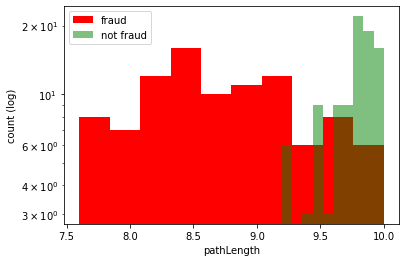

In [14]:
plot_relationship(norm_data=norm_pL,fraud_data=fraud_pL,feature_name="pathLength")

### Appears that fraud cases do have shorter pathLength than non fraud cases even though pathLength is not normalized by tree depth 

### Use more sophiscated Sklearn Isolation forest 

### the parameters are from trial and error 

In [15]:
contam=training.Class.value_counts(normalize=True).loc[1] 
iFor_norm = IsolationForest(n_estimators=80, max_samples=0.8, contamination=contam*1.5,max_features=1.0, 
                        bootstrap=False,random_state=42, n_jobs=20)
iFor_all = IsolationForest(n_estimators=80, max_samples=0.8, contamination=contam*1.5,max_features=1.0, 
                        bootstrap=False,random_state=42, n_jobs=20)

### Isolation Forest is supposed to be insensitive to outliers in the training dataset and we shall see if we get comparable outcome with normal vs data with fraud observations 

In [16]:
iFor_norm.fit(norm)
iFor_all.fit(training.drop("Class",axis=1))

IsolationForest(contamination=0.002607035484649652, max_samples=0.8,
                n_estimators=80, n_jobs=20, random_state=42)

In [17]:
pred_score_norm = iFor_norm.decision_function(test_data)
pred_score_all = iFor_all.decision_function(test_data)

In [18]:
pd.DataFrame(pred_score_all).describe()

,0
count,56962.000000
mean,0.160984
std,0.020926
min,-0.295073
25%,0.157049
50%,0.165796
75%,0.171551
max,0.183105


In [19]:
pd.DataFrame(pred_score_norm).describe()

,0
count,56962.000000
mean,0.150670
std,0.023083
min,-0.318697
25%,0.145813
50%,0.155953
75%,0.162389
max,0.173886


In [20]:
model_results(y_test,-pred_score_norm,0.0)  # negative score in sklearn version means abnormal 

[[56722   144]
 [   36    60]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.29      0.62      0.40        96

    accuracy                           1.00     56962
   macro avg       0.65      0.81      0.70     56962
weighted avg       1.00      1.00      1.00     56962



In [21]:
model_results(y_test,-pred_score_all,0.0) 

[[56776    90]
 [   53    43]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.32      0.45      0.38        96

    accuracy                           1.00     56962
   macro avg       0.66      0.72      0.69     56962
weighted avg       1.00      1.00      1.00     56962



### Didn't appear to have a huge difference if train on all normal or contaminated samples. 

* but proves that Isolation forest is not as sensitive to outlier the same way as OneClassSVM but normal class only is still better 

### Use gridSearchCV to perform more systematic parameter optimization

#### Define Custom Score

In [22]:
custom_score = make_custom_score()

### Define custom train and test splits 

In [23]:
cvSplits,X_train,y_train = makeCustomSplits(training,"Class",5,208,contam)

### training parameter and CV grid 

In [24]:
parameters = {
              "n_estimators":[50,80,120],
              "max_samples":["auto",0.5,0.8],
              "contamination":[contam, contam*1.5],
}

CV = GridSearchCV(IsolationForest(bootstrap=False,max_features=1),
                  parameters,
                  scoring=custom_score,
                  refit=False,
                  n_jobs=20,
                  verbose=1,
                  cv=cvSplits
                 )

In [25]:
CV.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   17.2s
[Parallel(n_jobs=20)]: Done  90 out of  90 | elapsed:  2.2min finished


GridSearchCV(cv=<generator object makeCustomSplits.<locals>.<genexpr> at 0x7fe2ba202ca8>,
             estimator=IsolationForest(max_features=1), n_jobs=20,
             param_grid={'contamination': [0.0017380236564331015,
                                           0.002607035484649652],
                         'max_samples': ['auto', 0.5, 0.8],
                         'n_estimators': [50, 80, 120]},
             refit=False,
             scoring={'f1_f': make_scorer(f1_f), 'fn': make_scorer(fn),
                      'fp': make_scorer(fp), 'prec_f': make_scorer(prec_f),
                      'recall_f': make_scorer(recall_f),
                      'tp': make_scorer(tp)},
             verbose=1)

In [26]:
df_output = CVResultsOutput(CV.cv_results_,custom_score.keys())

In [27]:
df_output

,contamination,max_samples,n_estimators,tp,fp,fn,f1_f,prec_f,recall_f
0,0.001738,auto,50,28.4,81.4,50.6,0.299580,0.257657,0.359494
1,0.001738,auto,80,27.6,78.0,51.4,0.297709,0.260102,0.349367
2,0.001738,auto,120,26.6,80.8,52.4,0.284928,0.247730,0.336709
3,0.001738,0.5,50,32.6,82.8,46.4,0.335285,0.283019,0.412658
4,0.001738,0.5,80,30.0,85.0,49.0,0.308334,0.260132,0.379747
5,0.001738,0.5,120,33.6,85.4,45.4,0.338068,0.280952,0.425316
6,0.001738,0.8,50,31.6,90.6,47.4,0.315018,0.260685,0.400000
7,0.001738,0.8,80,35.8,86.2,43.2,0.356197,0.294015,0.453165
8,0.001738,0.8,120,37.2,94.6,41.8,0.353030,0.283215,0.470886
9,0.002607,auto,50,30.6,120.6,48.4,0.263187,0.199706,0.387342


### Instead of using best selected estimator, use the output with the best overall tp,fp,fn

In [30]:
best_model = IsolationForest(n_estimators=80,max_samples=0.5,contamination=contam*1.5)

In [31]:
best_model.fit(norm)

IsolationForest(contamination=0.002607035484649652, max_samples=0.5,
                n_estimators=80)

In [32]:
best_pred_score = best_model.decision_function(test_data)

In [33]:
model_results(y_test,-best_pred_score,-0.0)

[[56729   137]
 [   29    67]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.33      0.70      0.45        96

    accuracy                           1.00     56962
   macro avg       0.66      0.85      0.72     56962
weighted avg       1.00      1.00      1.00     56962



### It appears that gridSearch with this approach does better than orthogonal tuning